In [167]:
import requests
import pickle
import pandas as pd
import json as js
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from sklearn.cluster import KMeans
from matplotlib.dates import DateFormatter, date2num
import plotly.express as px
import math
import datetime as dt
import matplotlib.lines as mlines

In [168]:
players_df = pd.concat(map(pd.read_csv, ['players_df_2021_1.csv', 'players_df_2021_2.csv']))
teams_df = pd.concat(map(pd.read_csv, ['teams_df_2021_1.csv', 'teams_df_2021_2.csv']))
teams_df = teams_df.drop_duplicates()
teams_df = teams_df.sort_values('id')
games_df = pd.concat(map(pd.read_csv, ['games_df_2021_1.csv', 'games_df_2021_2.csv']))
#events_df = pd.read_csv('events_df.csv')
#players_df.to_csv('players_final.csv')
#teams_df.to_csv('teams_final.csv')
#games_df.to_csv('games_final.csv')

In [169]:
events_df = pd.concat(map(pd.read_csv, ['events_df_2021_1.csv', 'events_df_2021_2.csv']))

In [170]:
#EVENTS_DF cicomazas
#Nullas sorok feltoltese hogy utana int-re valtoztathassuk
events_df = events_df.fillna(0)
events_df = events_df.astype({'player1Id': 'int64','player2Id':'int64','player3Id':'int64','player4Id':'int64',
                              'coX': 'int64','coY':'int64'})

In [171]:
#Distinct jatek datumok uj dataframeben mert az elejen elfelejtettem belevenni a read api-ba
date_df =  games_df.loc[:,['pk','startDate']]
#Ramergeljuk az events_df-re
events_df = pd.merge(left=events_df, right=date_df, left_on='gameId', right_on='pk', how='left')
events_df = events_df.drop(columns=['pk'])
#A datum vegerol levagjuk a felesleges reszt hogy szep legyen
events_df['startDate'] = events_df['startDate'].str[:10]

In [172]:
#A periodTime konvertalasa Timedelta tipusra
events_df['periodTimeFull'] = pd.to_timedelta(events_df['periodTime'].apply(lambda x: f'00:{x}'))
#periodtime atszamitasa teljes idotartamra a 3x20 perc helyett
events_df['periodTimeFull']  = events_df['periodTimeFull'] + ((events_df['period']-1) * pd.to_timedelta('00:20:00'))
#Kerekitjuk percekre
events_df['periodTimeFull_rounded'] = events_df['periodTimeFull'].dt.round('60s')

In [173]:
#Tukrozzuk az esemenyeket az origora, nagyon sokaig tart...
for idx, i in enumerate(events_df['coX']):
    if i<0:
        events_df['coX'].iloc[idx] = abs(events_df['coX'].iloc[idx])
        events_df['coY'].iloc[idx] = events_df['coY'].iloc[idx]*-1

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_57337/31992080.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['coX'].iloc[idx] = abs(events_df['coX'].iloc[idx])
/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_57337/31992080.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['coY'].iloc[idx] = events_df['coY'].iloc[idx]*-1


In [174]:
#Shot distance and angle
goalcenter_x = 89
goalcenter_y = 0

events_df['shot_angle'] = events_df[['coX','coY']].apply(
    lambda row: np.arctan(row['coY']/(goalcenter_x-row['coX']))*(180/np.pi),
    axis=1)

events_df['shot_distance'] = events_df[['coX','coY']].apply(
    lambda row: np.sqrt((row['coX']-goalcenter_x)**2 + (row['coY']-goalcenter_y)**2), axis=1)

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_57337/3611514764.py:6: RuntimeWarning: divide by zero encountered in long_scalars
  lambda row: np.arctan(row['coY']/(goalcenter_x-row['coX']))*(180/np.pi),


In [1344]:
#events_df.dtypes
#events_df[300:]
#events_df.to_csv('events_final.csv')

In [175]:
#Data Exploratory: Weight and height convert

#Weights from lbs to kg
weight = np.array(players_df['weight'])
x = 0
for i in weight:
    weight[x] = round(i * 0.453592, 1)
    x += 1
    
#Heights from feet and inches to cm
height = np.array(players_df['height'])
y = 0
for i in height:
    height[y] = int(i[0:1])*30.48 + int(i[2:i.find('""')])*2.54
    y += 1

players_df['weight_kg'] = weight
players_df['height_cm'] = height

In [176]:
players_distinct = players_df
players_distinct = players_distinct.drop(columns='gameId')
players_distinct = players_distinct.drop_duplicates()

In [188]:
players_distinct = players_distinct.astype({'height_cm': 'int64'})
players_distinct.dtypes

id                      int64
fullName               object
link                   object
firstName              object
lastName               object
primaryNumber         float64
birthDate              object
currentAge              int64
birthCity              object
birthStateProvince     object
birthCountry           object
nationality            object
height                 object
weight                  int64
active                   bool
alternateCaptain         bool
captain                  bool
rookie                   bool
shootsCatches          object
rosterStatus           object
teamID                  int64
pPos                   object
weight_kg               int64
height_cm               int64
dtype: object

In [177]:
#Data Exploratory: Atlagos eletkor
avg_age = pd.DataFrame()
avg_age = round(players_df.groupby('teamID')['currentAge'].mean(),1).sort_values()
teamsname = teams_df[['id','name']]
agebyteams = pd.merge(left=avg_age, right=teamsname, left_on='teamID', right_on='id', how='left')
agebyteams
#avg_age
#plt.hist(avg_age)

,currentAge,id,name
0,25.7,1,New Jersey Devils
1,26.2,29,Columbus Blue Jackets
2,26.5,9,Ottawa Senators
3,26.6,3,New York Rangers
4,26.6,26,Los Angeles Kings
5,26.7,7,Buffalo Sabres
6,26.8,17,Detroit Red Wings
7,27.2,16,Chicago Blackhawks
8,27.4,18,Nashville Predators
9,27.5,8,Montréal Canadiens


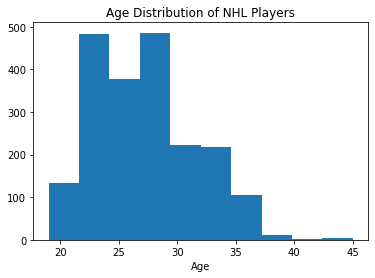

In [178]:
plt.hist(players_distinct['currentAge'])
plt.title('Age Distribution of NHL Players')
plt.xlabel('Age')
plt.show()

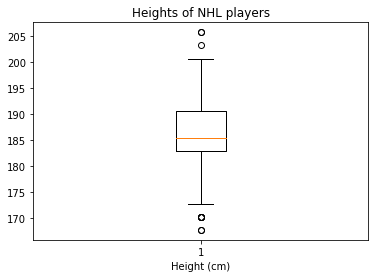

In [179]:
plt.boxplot(players_distinct['height_cm'])
plt.title('Heights of NHL players')
plt.xlabel('Height (cm)')
plt.show()

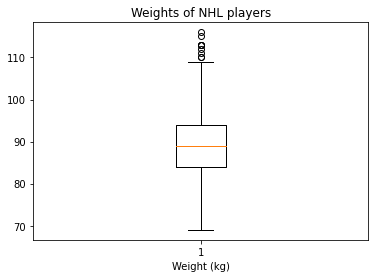

In [180]:
plt.boxplot(players_distinct['weight_kg'])
plt.title('Weights of NHL players')
plt.xlabel('Weight (kg)')
plt.show()

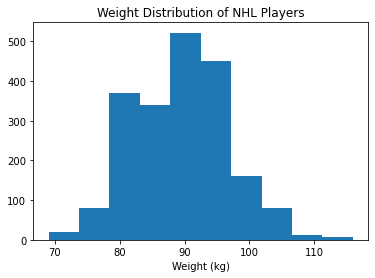

In [181]:
#Data Exploratory: Distribution of weights
plt.hist(players_distinct['weight_kg'])
plt.title('Weight Distribution of NHL Players')
plt.xlabel('Weight (kg)')
plt.show()

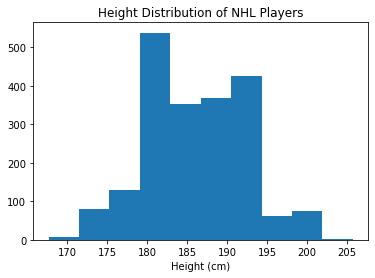

In [182]:
#Data Exploratory: Distribution of heights
plt.hist(players_distinct['height_cm'])
plt.title('Height Distribution of NHL Players')
plt.xlabel('Height (cm)')
plt.show()

In [183]:
players_distinct['weight_kg'].describe()

count    2042.000000
mean       89.372674
std         7.037918
min        69.000000
25%        84.000000
50%        89.000000
75%        94.000000
max       116.000000
Name: weight_kg, dtype: float64

In [184]:
players_distinct['height_cm'].describe()

count     2042.00
unique      16.00
top        187.96
freq       368.00
Name: height_cm, dtype: float64

Text(0, 0.5, 'Weight (kg)')

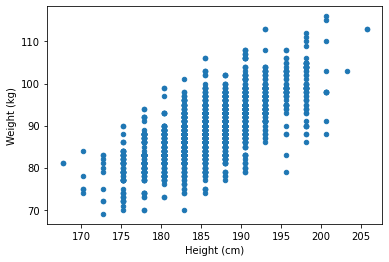

In [185]:
players_distinct.plot(x='height_cm',y='weight_kg', kind='scatter',s=20)
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')

Text(0, 0.5, 'Weight (kg)')

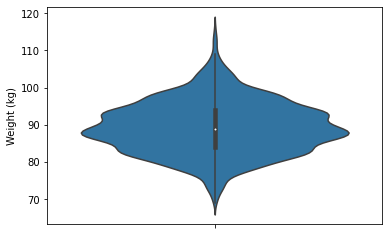

In [186]:
ax = sb.violinplot(y=players_distinct['weight_kg'])
ax.set_ylabel('Weight (kg)')

Text(0, 0.5, 'Height (cm)')

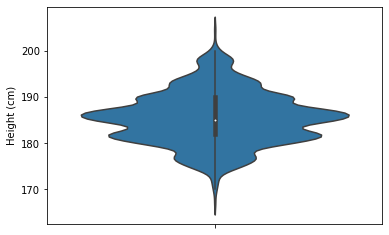

In [189]:
ax = sb.violinplot(y=players_distinct['height_cm'])
ax.set_ylabel('Height (cm)')

In [190]:
#Uj dataframe meghatarozott ember meghatarozott esemenyeivel
sog_df = pd.DataFrame()
sog_df = events_df[events_df['eventType'].isin(['Goal'])]
sog_df = sog_df[sog_df['player1Id'].isin([8471214])]
sog_df = sog_df[sog_df['periodType'] != 'SHOOTOUT']
sog_df = sog_df.drop_duplicates()

#for idx, i in enumerate(sog_df['coX']):
 #   if i<0:
  #      sog_df['coX'].iloc[idx] = abs(sog_df['coX'].iloc[idx])
   #     sog_df['coY'].iloc[idx] = sog_df['coY'].iloc[idx]*-1

sog_df

,gameId,eventId,eventType,eventTypeDesc,period,periodTime,periodType,teamAwayID,teamHomeID,goalsHome,...,player3Type,player3Name,player4Id,player4Type,player4Name,startDate,periodTimeFull,periodTimeFull_rounded,shot_angle,shot_distance
1223,2021020004,213,Goal,"Alex Ovechkin (1) Wrist Shot, assists: Anthony...",3,02:37,REGULAR,3,15,4,...,Assist,John Carlson,8480382,Goalie,Alexandar Georgiev,2021-10-13,0 days 00:42:37,0 days 00:43:00,49.763642,17.029386
1267,2021020004,257,Goal,"Alex Ovechkin (2) Backhand, assists: Evgeny Ku...",3,12:01,REGULAR,3,15,5,...,Assist,Trevor van Riemsdyk,8480382,Goalie,Alexandar Georgiev,2021-10-13,0 days 00:52:01,0 days 00:52:00,30.963757,5.830952
8630,2021020027,189,Goal,"Alex Ovechkin (3) Snap Shot, assists: Trevor v...",2,18:51,REGULAR,14,15,1,...,Assist,Tom Wilson,8476883,Goalie,Andrei Vasilevskiy,2021-10-16,0 days 00:38:51,0 days 00:39:00,-3.691386,31.064449
14302,2021020045,288,Goal,"Alex Ovechkin (4) Wrist Shot, assists: Tom Wil...",3,17:39,REGULAR,21,15,6,...,Assist,Evgeny Kuznetsov,0,0,0,2021-10-19,0 days 00:57:39,0 days 00:58:00,30.256437,41.677332
22731,2021020072,182,Goal,"Alex Ovechkin (5) Wrist Shot, assists: none",2,18:03,REGULAR,20,15,3,...,0,0,0,0,0,2021-10-23,0 days 00:38:03,0 days 00:38:00,35.753887,30.805844
26513,2021020084,230,Goal,"Alex Ovechkin (6) Wrist Shot, assists: none",2,16:27,REGULAR,15,9,4,...,0,0,0,0,0,2021-10-25,0 days 00:36:27,0 days 00:36:00,-16.699244,10.440307
26584,2021020084,301,Goal,"Alex Ovechkin (7) Wrist Shot, assists: Tom Wil...",3,10:46,REGULAR,15,9,5,...,Goalie,Filip Gustavsson,0,0,0,2021-10-25,0 days 00:50:46,0 days 00:51:00,16.389540,35.440090
30770,2021020098,78,Goal,"Alex Ovechkin (8) Snap Shot, assists: Lars Ell...",1,19:05,REGULAR,17,15,1,...,Assist,Anthony Mantha,8471306,Goalie,Thomas Greiss,2021-10-27,0 days 00:19:05,0 days 00:19:00,66.801409,7.615773
35618,2021020113,262,Goal,"Alex Ovechkin (9) Wrist Shot, assists: Evgeny ...",3,19:39,REGULAR,53,15,2,...,Assist,John Carlson,0,0,0,2021-10-29,0 days 00:59:39,0 days 01:00:00,21.194056,52.554733
47827,2021020152,217,Goal,"Alex Ovechkin (10) Wrist Shot, assists: Lars E...",2,18:11,REGULAR,15,13,4,...,Goalie,Spencer Knight,0,0,0,2021-11-04,0 days 00:38:11,0 days 00:38:00,25.769328,32.202484


In [191]:
#Meghatarozzuk, hany klaszter erdemes letrehozni a koordinatakra (a konyokpont erteke kell nekunk, ahonnan mar
#nem novekszik tovabb lavanyosan a fgv.)
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = events_df[['coX']]
X_axis = events_df[['coY']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

KeyboardInterrupt: 

In [192]:
#Letrehozunk egy uj dataframet a koordinatas vizualizaciohoz az x es y koordinatakkal
X = sog_df.loc[:,['coX','coY']]

X_round = sog_df.loc[:,['coX','coY']]

#Uj dataframe, szamok kerekitve a masodik fajta vizualizaciohoz, hogy a szinek jol nezzenek ki:
for idx, i in X_round.iterrows():
    X_round.loc[idx,'coX'] = (round(X_round.loc[idx,'coX']/5.0)*5.0)
    X_round.loc[idx,'coY'] = (round(X_round.loc[idx,'coY']/5.0)*5.0)
#X


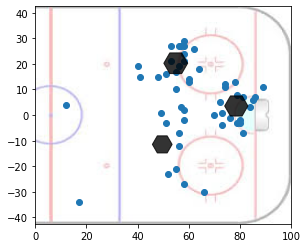

In [193]:
#A meghatarozott klaszterszamot megadva klaszterekbe soroljuk a koordinatakat
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[0:2]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[0:2]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[0:2]]) # Labels of each point

#Kiszamoljuk a pottyok meretet, a klaszterek elemszamat vesszuk es megszorozzuk valamennyiel, hogy nagyobb legyen.
size = X.groupby(['cluster_label']).count()
size = size['coX']*30

#Ket valtozot inicializalunk aminek megadjuk az X es Y oszlopunkat, hogy kesobb be tudjuk taplalni a plot-ba
coX = X['coX']
coY = X['coY']
img = plt.imread('hockeyrink.jpeg')
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 100, -42.5, 42.5])
ax.scatter(X['coX'], X['coY'])
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=size, marker='H', alpha=0.8)
plt.xlim(0,100)
plt.ylim(-42.5,42.5)
plt.show()

In [61]:
#Goal - Assist pairs
Y = sog_df.loc[:,['player1Id','player2Id']]
Y = Y.groupby(['player1Id', 'player2Id']).size().sort_values(ascending=False).reset_index(name='count') 
Y

,player1Id,player2Id,count
0,8471214,8475744,15
1,8471214,8474590,8
2,8471214,8475200,4
3,8471214,8476880,4
4,8471214,8477839,2
5,8471214,8473563,2
6,8471214,8474189,2
7,8471214,8477903,2
8,8471214,8477845,2
9,8471214,0,1


In [235]:
assists = events_df.loc[:,['player1Id', 'player1Name', 'player2Id', 'player2Name','eventType','periodType']]
assists = assists[assists['periodType'] != 'SHOOTOUT']
assists = assists[assists['eventType'].isin(['Goal'])]
assists = assists.groupby(['player1Id','player1Name', 'player2Name']).size().sort_values(ascending=False).reset_index(name='count') 
assists = assists[assists['player1Name'].isin(['Alex Ovechkin'])]
assists = assists.rename(columns={"player1Name": "Scorer", 'player2Name':'First Assist','count':'#'} )
assists

,player1Id,Scorer,First Assist,#
6,8471214,Alex Ovechkin,Evgeny Kuznetsov,15
65,8471214,Alex Ovechkin,John Carlson,8
314,8471214,Alex Ovechkin,Dmitry Orlov,4
337,8471214,Alex Ovechkin,Tom Wilson,4
1395,8471214,Alex Ovechkin,Lars Eller,2
1402,8471214,Alex Ovechkin,Nicklas Backstrom,2
1408,8471214,Alex Ovechkin,Trevor van Riemsdyk,2
1420,8471214,Alex Ovechkin,Garnet Hathaway,2
1424,8471214,Alex Ovechkin,Conor Sheary,2
3635,8471214,Alex Ovechkin,0,1


In [240]:
assists = events_df.loc[:,['player1Name','player2Name','eventType','periodType']]
assists = assists[assists['periodType'] != 'SHOOTOUT']
assists = assists[assists['eventType'].isin(['Goal'])]
assists = assists.groupby(['player1Name', 'player2Name']).size().sort_values(ascending=False).reset_index(name='#') 
assists = assists[assists['player1Name'].isin(['Alex Ovechkin'])]
assists = assists.rename(columns={"player1Name": "Scorer", 'player2Name':'First Assist'} )
assists

,Scorer,First Assist,#
4,Alex Ovechkin,Evgeny Kuznetsov,15
76,Alex Ovechkin,John Carlson,8
331,Alex Ovechkin,Dmitry Orlov,4
337,Alex Ovechkin,Tom Wilson,4
1012,Alex Ovechkin,Trevor van Riemsdyk,2
1013,Alex Ovechkin,Nicklas Backstrom,2
1018,Alex Ovechkin,Lars Eller,2
1019,Alex Ovechkin,Garnet Hathaway,2
1025,Alex Ovechkin,Conor Sheary,2
3593,Alex Ovechkin,0,1


In [195]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
df_counts = X_round.groupby(['coX', 'coY']).size().reset_index(name='counts')

fig = px.scatter(df_counts, x='coX', y='coY',
                 color='counts',
                 size='counts',
                 width=685, height=580)

fig.update_layout(yaxis_range=[-42.5,42.5])
fig.update_layout(xaxis_range=[0,100])

# Remove side scale and hide zero and gridlines
fig.update_layout(
    coloraxis_showscale=True,
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),)
# Disable axis ticks and labels
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='')

fig.add_layout_image(
        dict(
            source='Half_ice_hockey_rink.png',
            xref="x",
            yref="y",
            x=0,
            y=42,
            sizex=100,
            sizey=85,
            sizing="stretch",
            opacity=0.5,
            layer="below")
)

fig.update_layout(template="plotly_white")
#df_counts
fig.show()

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_57337/1790363992.py:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_57337/1790363992.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_57337/1790363992.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



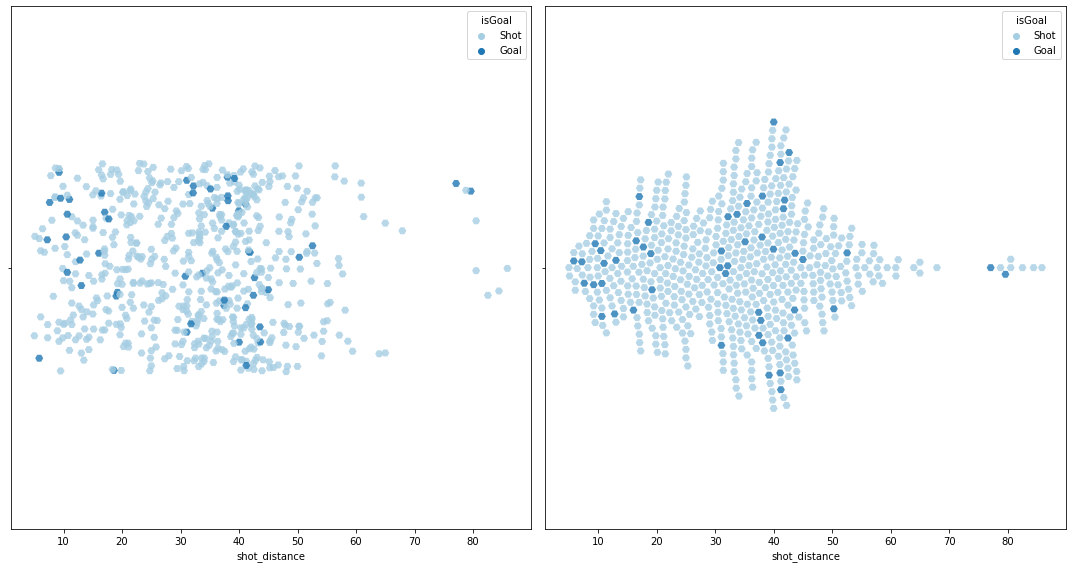

In [196]:
#Koordinatakban van megadva a tavolsag, atszamolni meterre?
dist1 = events_df[['shot_distance','player1Id','eventType','periodType']]
dist1 = dist1[dist1['periodType'] != 'SHOOTOUT']
dist1 = dist1[dist1['eventType'].isin(['Shot','Missed Shot','Goal'])]
dist1 = dist1[dist1['player1Id'].isin([8471214])]

dist2 = events_df[['shot_distance','player2Id','eventType','periodType']]
dist2 = dist2[dist2['periodType'] != 'SHOOTOUT']
dist2 = dist2[dist2['eventType'].isin(['Blocked Shot'])]
dist2 = dist2.rename(columns={"player2Id": "player1Id"})
dist2 = dist2[dist2['player1Id'].isin([8471214])]

dist = dist1.append(dist2, ignore_index=True)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))

dist['isGoal'] = ''

for idx, i in enumerate(dist['eventType']):
    if i == 'Goal':
        dist['isGoal'].iloc[idx] = "Goal"
    else:
        dist['isGoal'].iloc[idx] = "Shot"
        

sb.stripplot(data=dist, x=dist['shot_distance'], y=[""]*len(dist), ax=ax1, hue=dist['isGoal'],palette="Paired", 
             size=8, marker="H", edgecolor="gray", alpha=.8, jitter = .2)

sb.swarmplot(data=dist, x=dist['shot_distance'], ax=ax2,  y=[""]*len(dist),hue=dist['isGoal'],palette=('Paired'), 
             size=8, marker="H",edgecolor="gray",alpha=.8)

plt.tight_layout()

In [238]:
all_sog1 = events_df[['player1Id','eventType','periodType']]
all_sog1 = all_sog1[all_sog1['periodType'] != 'SHOOTOUT']
all_sog1 = all_sog1[all_sog1['eventType'].isin(['Shot','Missed Shot','Goal'])]

all_sog2 = events_df[['player2Id','eventType','periodType']]
all_sog2 = all_sog2[all_sog2['periodType'] != 'SHOOTOUT']
all_sog2 = all_sog2[all_sog2['eventType'].isin(['Blocked Shot'])]
all_sog2 = all_sog2.rename(columns={"player2Id": "player1Id"})

all_sog = all_sog1.append(all_sog2, ignore_index=True)

all_sog = all_sog[all_sog['player1Id'].isin([8471214])]

all_sog = all_sog.groupby(['eventType']).size().sort_values(ascending=False).reset_index(name='player1Id') 

all_sog = all_sog.rename(columns={"player1Id": "#", 'eventType':'Shot Type'})

all_sog['%'] = round((all_sog['#'] / all_sog['#'].sum())*100,2)

all_sog

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_57337/3196334590.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Shot Type,#,%
0,Shot,284,44.24
1,Blocked Shot,174,27.10
2,Missed Shot,134,20.87
3,Goal,50,7.79


In [1180]:
#events_df.player1Type.unique() #'Winner', 'Scorer', 'Shooter', 'PenaltyOn', 'PlayerID','Blocker', 'Hitter'
#events_df.player2Type.unique() #'Loser', 'Assist', 'DrewBy', 'Goalie', 'Shooter', 'Hittee' 
    #(Blocked Shot-nal elso a Blocker masodik a Shooter)
#events_df.player3Type.unique() #'Assist', 'Goalie', 'ServedBy'
#events_df.player4Type.unique() #'Golie'
#events_df.eventType.unique()

Text(0, 0.5, 'SH%')

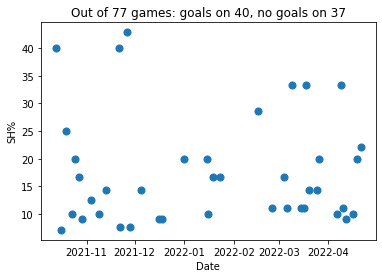

In [231]:
#Shots on Goal % szamitas.
#Elso temp DataFrame: osszes kapuraloves a player 1-tol
tmp_sog = events_df[['gameId','player1Id','startDate','eventType','periodType']]
tmp_sog = tmp_sog[tmp_sog['periodType'] != 'SHOOTOUT']
tmp_sog = tmp_sog[tmp_sog['eventType'].isin(['Shot','Missed Shot','Goal'])]
tmp_sog_calc = tmp_sog.groupby(['gameId','startDate','player1Id']).count()
tmp_sog_calc = tmp_sog_calc.rename(columns={"eventType": "allShots"})
tmp_sog_calc.reset_index(inplace=True)
#tmp_sog_calc

#Masodik temp dataframe: osszes kapuraloves a player 2-tol (Blocked Shot-nal player 2-n van logolva a Shooter)
tmp_sog_b = events_df[['gameId','player2Id','startDate','eventType','periodType']]
tmp_sog_b = tmp_sog_b[tmp_sog_b['periodType'] != 'SHOOTOUT']
tmp_sog_b = tmp_sog_b[tmp_sog_b['eventType'].isin(['Blocked Shot'])]
tmp_sog_calc_b = tmp_sog_b.groupby(['gameId','startDate','player2Id']).count()
tmp_sog_calc_b = tmp_sog_calc_b.rename(columns={"eventType": "allShots"})
tmp_sog_calc_b.reset_index(inplace=True)
#tmp_sog_calc_b

#Harmadik temp DataFrame: Az osszes kapuraloves
tmp_allsog = pd.merge(left=tmp_sog_calc, right=tmp_sog_calc_b, 
                          left_on=['gameId','startDate','player1Id'], right_on=['gameId','startDate','player2Id'], 
                          how='left')
tmp_allsog = tmp_allsog.fillna(0)
tmp_allsog = tmp_allsog.astype({'allShots_y': 'int64'})
tmp_allsog['allShots'] = tmp_allsog['allShots_x']+tmp_allsog['allShots_y']
tmp_allsog = tmp_allsog.drop(columns=['allShots_x','player2Id','allShots_y'])
#tmp_allsog

#Negyedik temp DataFrame: Az osszes Goal
tmp_goal = events_df[['gameId','player1Id','startDate','eventType','periodType']]
tmp_goal = tmp_goal[tmp_goal['periodType'] != 'SHOOTOUT']
tmp_goal = tmp_goal[tmp_goal['eventType'].isin(['Goal'])]
tmp_goal_calc = tmp_goal.groupby(['gameId','startDate','player1Id']).count()
tmp_goal_calc = tmp_goal_calc.rename(columns={"eventType": "allGoals"})
tmp_goal_calc.reset_index()

#Vegso DataFrame: Osszes kapuraloves es goal merge, szazalek szamitas
sog_percentage = pd.merge(left=tmp_allsog, right=tmp_goal_calc, 
                          left_on=['gameId','startDate','player1Id'], right_on=['gameId','startDate','player1Id'], 
                          how='left')

sog_percentage['sog%'] = round(((sog_percentage['allGoals']/sog_percentage['allShots'])*100),1)
sog_percentage["Date"] = pd.to_datetime(sog_percentage["startDate"])
sog_percentage.reset_index(inplace=True)

sog_null = sog_percentage.fillna(0)
sog_null = sog_null[sog_null['player1Id'].isin([8471214])]
sog_null = sog_null[sog_null['allGoals'] < 1]
nogoal = sog_null.shape[0]

goaldf = sog_percentage.fillna(0)
goaldf = goaldf[goaldf['player1Id'].isin([8471214])]
goaldf = goaldf[goaldf['allGoals'] > 0]
goal = goaldf.shape[0]


#nogoal+goal

sog_percentage = sog_percentage[sog_percentage['player1Id'].isin([8471214])]
sog_percentage.plot(x='Date',y='sog%', kind='scatter',s=50)
allgame = sog_percentage.shape[0]
plt.title('Out of '+str(allgame)+' games: goals on '+str(goal)+', no goals on '+str(nogoal))
plt.xlabel('Date')
plt.ylabel('SH%')

In [233]:
hattrick = sog_percentage[sog_percentage['allGoals'] >= 3]
hattrickcount = hattrick.shape[0]

        
sog_percentage.shape

(77, 11)

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_13054/1981558009.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Text(0.5, 0, 'Period Time')

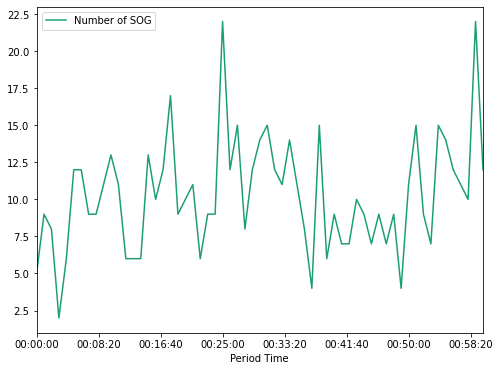

In [292]:
#Timeline: X axis-on a 60 perc, esemenyeket percre kerekitem. A szezon osszes kapuralovese az adott percben adott embertol
#A kapuraloves lehet: 'Shot','Missed Shot','Goal' es 'Blocked Shot'. Blokkoltnal a Player2-n van logolva a Shooter
#REGULAR period type
tmp_sog_time = events_df[['player1Id','eventType','periodTimeFull_rounded']]
tmp_sog_time = tmp_sog_time[tmp_sog_time['eventType'].isin(['Shot','Missed Shot','Goal'])]

tmp_sog_b_time = events_df[['player2Id','eventType','periodTimeFull_rounded']]
tmp_sog_b_time = tmp_sog_b_time[tmp_sog_b_time['eventType'].isin(['Blocked Shot'])]
tmp_sog_b_time = tmp_sog_b_time.rename(columns={"player2Id": "player1Id"})

timechart = tmp_sog_time.append(tmp_sog_b_time, ignore_index=True)

#REGULAR period type (OverTime es Shootout kiszurese):
timechart = timechart.loc[timechart['periodTimeFull_rounded'] <= pd.to_timedelta('01:00:00')]

timechart = timechart[timechart['player1Id'].isin([8471214])]

timechart = timechart.groupby(['periodTimeFull_rounded']).count()
timechart = timechart.drop(columns=['eventType'])
timechart = timechart.rename(columns={"player1Id": "Number of SOG"})
timechart.reset_index(inplace=True)
timechart.plot(x='periodTimeFull_rounded', figsize=(8,6), cmap='Dark2')
plt.xlabel('Period Time')
#px.line(timechart, x="periodTimeFull_rounded", y="Number of SOG", title='# of SOG')
#timechart

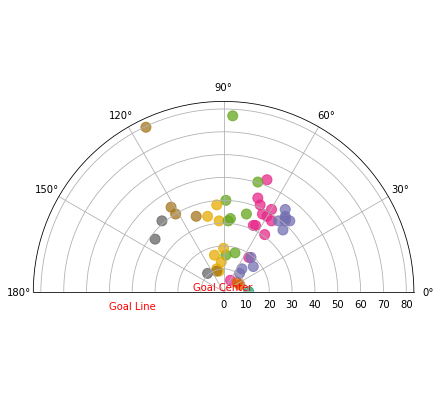

In [210]:
#Szogek vizualizalasa
#Atszamoljuk radianra, aztan elforgatjuk hogy 0-180 kozott tudjam abrazolni
events_df['shot_angle_rad'] = events_df['shot_angle']*(math.pi/180)
events_df['shot_angle_vis'] = events_df['shot_angle_rad']*-1+(math.pi/2)

#Parameterek, pl Ovechkin goljai:
angledf = pd.DataFrame()
angledf = events_df[events_df['eventType'].isin(['Goal'])]
angledf = angledf[angledf['periodType'] != 'SHOOTOUT']
angledf = angledf[angledf['player1Id'].isin([8471214])]

theta = angledf['shot_angle_vis']
r = angledf['shot_distance']
colors = theta
size = angledf['shot_angle_vis'].count()*2

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
#bx = fig.add_subplot()
c = ax.scatter(theta, r, s=size, cmap='Dark2', c = colors, alpha=0.75)
plt.gcf().set_size_inches(8, 7)
img = plt.imread('hockeyrink.jpeg')

#bx.imshow(img, extent=[0, 100, -42.5, 42.5])
ax.text(0.2, 0.2, 'Goal Line',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='red', fontsize=10)
ax.text(0.42, 0.25, 'Goal Center',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='red', fontsize=10)
ax.set_thetamin(0)
ax.set_thetamax(180)

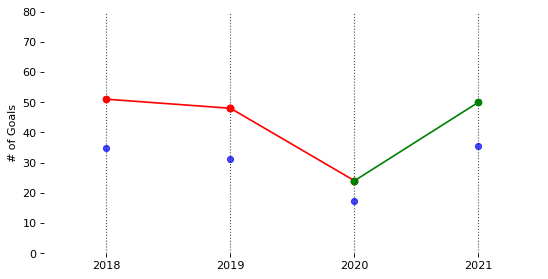

In [98]:
#Individual Expected Goals: ixG, letoltott csv-ben vannak statisztikai szamaim, ezt csak beolvasom, nem API-zok
players_stat_18 = pd.read_csv('playerstats_2018.csv')
players_stat_19 = pd.read_csv('playerstats_2019.csv')
players_stat_20 = pd.read_csv('playerstats_20.csv')
players_stat_21 = pd.read_csv('playerstats_21.csv')

name = 'Alex Ovechkin'

#Dataframek amiben csak az ixG kerul 1 emberre
oneplayerstat_18 = players_stat_18.loc[:,['Player', 'Goals', 'ixG','GP']]
oneplayerstat_18 = oneplayerstat_18[oneplayerstat_18['Player'] == (name)]
oneplayerstat_18 = oneplayerstat_18.rename(columns={"ixG": "ixG_18", 'Goals':'Goals_18','GP':'GP_18'})

oneplayerstat_19 = players_stat_19.loc[:,['Player', 'Goals', 'ixG','GP']]
oneplayerstat_19 = oneplayerstat_19[oneplayerstat_19['Player'] == (name)]
oneplayerstat_19 = oneplayerstat_19.rename(columns={"ixG": "ixG_19", 'Goals':'Goals_19','GP':'GP_19'})

oneplayerstat_20 = players_stat_20.loc[:,['Player', 'Goals', 'ixG','GP']]
oneplayerstat_20 = oneplayerstat_20[oneplayerstat_20['Player'] == (name)]
oneplayerstat_20 = oneplayerstat_20.rename(columns={"ixG": "ixG_20", 'Goals':'Goals_20','GP':'GP_20'})

oneplayerstat_21 = players_stat_21.loc[:,['Player', 'Goals', 'ixG','GP']]
oneplayerstat_21 = oneplayerstat_21[oneplayerstat_21['Player'] == (name)]
oneplayerstat_21 = oneplayerstat_21.rename(columns={"ixG": "ixG_21", 'Goals':'Goals_21','GP':'GP_21'})

fig, ax = plt.subplots(1,1,figsize=(8,4), dpi= 80)

#Vertical lines
ax.vlines(x=1, ymin=0, ymax=80, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=0, ymax=80, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=5, ymin=0, ymax=80, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=7, ymin=0, ymax=80, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

# Points
#Goals
ax.scatter(y=oneplayerstat_18['Goals_18'], x=np.repeat(1, oneplayerstat_18.shape[0]), s=10, color='black', alpha=0.7)
ax.scatter(y=oneplayerstat_19['Goals_19'], x=np.repeat(3, oneplayerstat_19.shape[0]), s=10, color='black', alpha=0.7)
ax.scatter(y=oneplayerstat_20['Goals_20'], x=np.repeat(5, oneplayerstat_20.shape[0]), s=10, color='black', alpha=0.7)
ax.scatter(y=oneplayerstat_21['Goals_21'], x=np.repeat(7, oneplayerstat_21.shape[0]), s=10, color='black', alpha=0.7)
#ixG
ax.scatter(y=oneplayerstat_18['ixG_18'], x=np.repeat(1, oneplayerstat_18.shape[0]), s=30, color='blue', alpha=0.7)
ax.scatter(y=oneplayerstat_19['ixG_19'], x=np.repeat(3, oneplayerstat_19.shape[0]), s=30, color='blue', alpha=0.7)
ax.scatter(y=oneplayerstat_20['ixG_20'], x=np.repeat(5, oneplayerstat_20.shape[0]), s=30, color='blue', alpha=0.7)
ax.scatter(y=oneplayerstat_21['ixG_21'], x=np.repeat(7, oneplayerstat_21.shape[0]), s=30, color='blue', alpha=0.7)

def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='red' if p1[1]-p2[1] > 0 else 'green', marker='o', markersize=6)
    ax.add_line(l)
    return l

# Line Segmentsand Annotation
for p1, p2 in zip(oneplayerstat_18['Goals_18'], oneplayerstat_19['Goals_19']):
    newline([1,p1], [3,p2])
    
for p1, p2 in zip(oneplayerstat_19['Goals_19'], oneplayerstat_20['Goals_20']):
    newline([3,p1], [5,p2])
    
for p1, p2 in zip(oneplayerstat_20['Goals_20'], oneplayerstat_21['Goals_21']):
    newline([5,p1], [7,p2])
    
# Decoration
#ax.set_title("Comparing Expected Goals and Goals in 2021", fontdict={'size':15})
ax.set(xlim=(0,8), ylim=(10,80), ylabel='# of Goals')
ax.set_xticks([1,3,5,7])
ax.set_xticklabels(["2018", "2019","2020","2021"])
plt.yticks((0,10,20,30,40,50,60,70,80), fontsize=10)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.0)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.0)


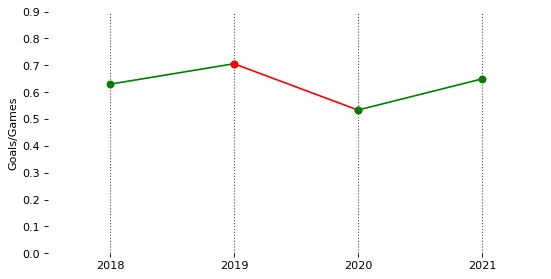

In [100]:
#Individual Expected Goals: ixG, letoltott csv-ben vannak statisztikai szamaim, ezt csak beolvasom, nem API-zok
players_stat_18 = pd.read_csv('playerstats_2018.csv')
players_stat_19 = pd.read_csv('playerstats_2019.csv')
players_stat_20 = pd.read_csv('playerstats_20.csv')
players_stat_21 = pd.read_csv('playerstats_21.csv')

name = 'Alex Ovechkin'

#Dataframek amiben csak az ixG kerul 1 emberre
oneplayerstat_18 = players_stat_18.loc[:,['Player', 'Goals', 'ixG','GP']]
oneplayerstat_18 = oneplayerstat_18[oneplayerstat_18['Player'] == (name)]
oneplayerstat_18 = oneplayerstat_18.rename(columns={"ixG": "ixG_18", 'Goals':'Goals_18','GP':'GP_18'})

oneplayerstat_19 = players_stat_19.loc[:,['Player', 'Goals', 'ixG','GP']]
oneplayerstat_19 = oneplayerstat_19[oneplayerstat_19['Player'] == (name)]
oneplayerstat_19 = oneplayerstat_19.rename(columns={"ixG": "ixG_19", 'Goals':'Goals_19','GP':'GP_19'})

oneplayerstat_20 = players_stat_20.loc[:,['Player', 'Goals', 'ixG','GP']]
oneplayerstat_20 = oneplayerstat_20[oneplayerstat_20['Player'] == (name)]
oneplayerstat_20 = oneplayerstat_20.rename(columns={"ixG": "ixG_20", 'Goals':'Goals_20','GP':'GP_20'})

oneplayerstat_21 = players_stat_21.loc[:,['Player', 'Goals', 'ixG','GP']]
oneplayerstat_21 = oneplayerstat_21[oneplayerstat_21['Player'] == (name)]
oneplayerstat_21 = oneplayerstat_21.rename(columns={"ixG": "ixG_21", 'Goals':'Goals_21','GP':'GP_21'})


#ixg_1819 = pd.merge(left=oneplayerstat_18, right=oneplayerstat_19, left_on = 'Player', right_on='Player', how='left')
#ixg = oneplayerstat_21

fig, ax = plt.subplots(1,1,figsize=(8,4), dpi= 80)

#Vertical lines
ax.vlines(x=1, ymin=0, ymax=2, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=0, ymax=2, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=5, ymin=0, ymax=2, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=7, ymin=0, ymax=2, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

gpg_18 = (oneplayerstat_18['Goals_18']/oneplayerstat_18['GP_18'])
gpg_19 = (oneplayerstat_19['Goals_19']/oneplayerstat_19['GP_19'])
gpg_20 = (oneplayerstat_20['Goals_20']/oneplayerstat_20['GP_20'])
gpg_21 = (oneplayerstat_21['Goals_21']/oneplayerstat_21['GP_21'])

# Points
#GP
ax.scatter(y=gpg_18, x=np.repeat(1, oneplayerstat_18.shape[0]), s=30, color='red', alpha=0.7)
ax.scatter(y=gpg_19, x=np.repeat(3, oneplayerstat_19.shape[0]), s=30, color='red', alpha=0.7)
ax.scatter(y=gpg_20, x=np.repeat(5, oneplayerstat_20.shape[0]), s=30, color='red', alpha=0.7)
ax.scatter(y=gpg_21, x=np.repeat(7, oneplayerstat_21.shape[0]), s=30, color='red', alpha=0.7)

def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='red' if p1[1]-p2[1] > 0 else 'green', marker='o', markersize=6)
    ax.add_line(l)
    return l

# Line Segmentsand Annotation
for p1, p2 in zip(gpg_18, gpg_19):
    newline([1,p1], [3,p2])
    
for p1, p2 in zip(gpg_19, gpg_20):
    newline([3,p1], [5,p2])
    
for p1, p2 in zip(gpg_20, gpg_21):
    newline([5,p1], [7,p2])
    
# Decoration
#ax.set_title("Comparing Expected Goals and Goals in 2021", fontdict={'size':15})
ax.set(xlim=(0,8), ylim=(0,0.9), ylabel='Goals/Games')
ax.set_xticks([1,3,5,7])
ax.set_xticklabels(["2018", "2019","2020","2021"])
plt.yticks((0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9), fontsize=10)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.0)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.0)


In [325]:
#players_df.dtypes

In [326]:
#teams_df.dtypes

In [327]:
#games_df.dtypes

In [328]:
#events_df.dtypes

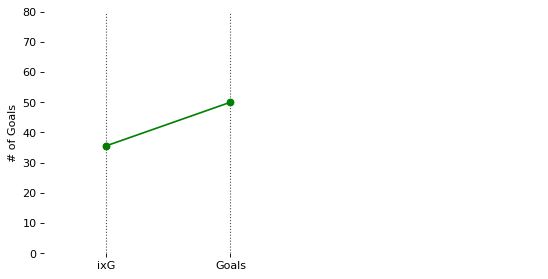

In [242]:
#Individual Expected Goals: ixG, letoltott csv-ben vannak statisztikai szamaim, ezt csak beolvasom, nem API-zok
players_stat_18 = pd.read_csv('playerstats_2018.csv')
players_stat_19 = pd.read_csv('playerstats_2019.csv')
players_stat_20 = pd.read_csv('playerstats_20.csv')
players_stat_21 = pd.read_csv('playerstats_21.csv')

name = 'Alex Ovechkin'

#Dataframek amiben csak az ixG kerul 1 emberre
oneplayerstat_18 = players_stat_18.loc[:,['Player', 'Goals', 'ixG','GP']]
oneplayerstat_18 = oneplayerstat_18[oneplayerstat_18['Player'] == (name)]
oneplayerstat_18 = oneplayerstat_18.rename(columns={"ixG": "ixG_18", 'Goals':'Goals_18','GP':'GP_18'})

oneplayerstat_19 = players_stat_19.loc[:,['Player', 'Goals', 'ixG','GP']]
oneplayerstat_19 = oneplayerstat_19[oneplayerstat_19['Player'] == (name)]
oneplayerstat_19 = oneplayerstat_19.rename(columns={"ixG": "ixG_19", 'Goals':'Goals_19','GP':'GP_19'})

oneplayerstat_20 = players_stat_20.loc[:,['Player', 'Goals', 'ixG','GP']]
oneplayerstat_20 = oneplayerstat_20[oneplayerstat_20['Player'] == (name)]
oneplayerstat_20 = oneplayerstat_20.rename(columns={"ixG": "ixG_20", 'Goals':'Goals_20','GP':'GP_20'})

oneplayerstat_21 = players_stat_21.loc[:,['Player', 'Goals', 'ixG','GP']]
oneplayerstat_21 = oneplayerstat_21[oneplayerstat_21['Player'] == (name)]
oneplayerstat_21 = oneplayerstat_21.rename(columns={"ixG": "ixG_21", 'Goals':'Goals_21','GP':'GP_21'})

fig, ax = plt.subplots(1,1,figsize=(8,4), dpi= 80)

#Vertical lines
ax.vlines(x=1, ymin=0, ymax=80, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=0, ymax=80, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
#ax.vlines(x=5, ymin=0, ymax=80, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
#ax.vlines(x=7, ymin=0, ymax=80, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

# Points
#Goals
#ax.scatter(y=oneplayerstat_18['Goals_18'], x=np.repeat(1, oneplayerstat_18.shape[0]), s=10, color='black', alpha=0.7)
ax.scatter(y=oneplayerstat_21['Goals_21'], x=np.repeat(3, oneplayerstat_21.shape[0]), s=10, color='black', alpha=0.7)
#ax.scatter(y=oneplayerstat_20['Goals_20'], x=np.repeat(5, oneplayerstat_20.shape[0]), s=10, color='black', alpha=0.7)
#ax.scatter(y=oneplayerstat_21['Goals_21'], x=np.repeat(7, oneplayerstat_21.shape[0]), s=10, color='black', alpha=0.7)
#ixG
ax.scatter(y=oneplayerstat_21['ixG_21'], x=np.repeat(1, oneplayerstat_21.shape[0]), s=30, color='black', alpha=0.7)
#ax.scatter(y=oneplayerstat_19['ixG_19'], x=np.repeat(3, oneplayerstat_19.shape[0]), s=30, color='blue', alpha=0.7)
#ax.scatter(y=oneplayerstat_20['ixG_20'], x=np.repeat(5, oneplayerstat_20.shape[0]), s=30, color='blue', alpha=0.7)
#ax.scatter(y=oneplayerstat_21['ixG_21'], x=np.repeat(7, oneplayerstat_21.shape[0]), s=30, color='blue', alpha=0.7)

def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='red' if p1[1]-p2[1] > 0 else 'green', marker='o', markersize=6)
    ax.add_line(l)
    return l

# Line Segmentsand Annotation
for p1, p2 in zip(oneplayerstat_21['ixG_21'], oneplayerstat_21['Goals_21']):
    newline([1,p1], [3,p2])
    
#for p1, p2 in zip(oneplayerstat_19['Goals_19'], oneplayerstat_20['Goals_20']):
 #   newline([3,p1], [5,p2])
    
#for p1, p2 in zip(oneplayerstat_20['Goals_20'], oneplayerstat_21['Goals_21']):
 #   newline([5,p1], [7,p2])
    
# Decoration
#ax.set_title("Comparing Expected Goals and Goals in 2021", fontdict={'size':15})
ax.set(xlim=(0,8), ylim=(10,80), ylabel='# of Goals')
ax.set_xticks([1,3])
ax.set_xticklabels(["ixG", "Goals"])
plt.yticks((0,10,20,30,40,50,60,70,80), fontsize=10)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.0)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.0)